# EVAC Examination

## Data Exploration

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [41]:
data = pd.read_csv('eScooterDemand.csv')
data.head()

,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No,Yes


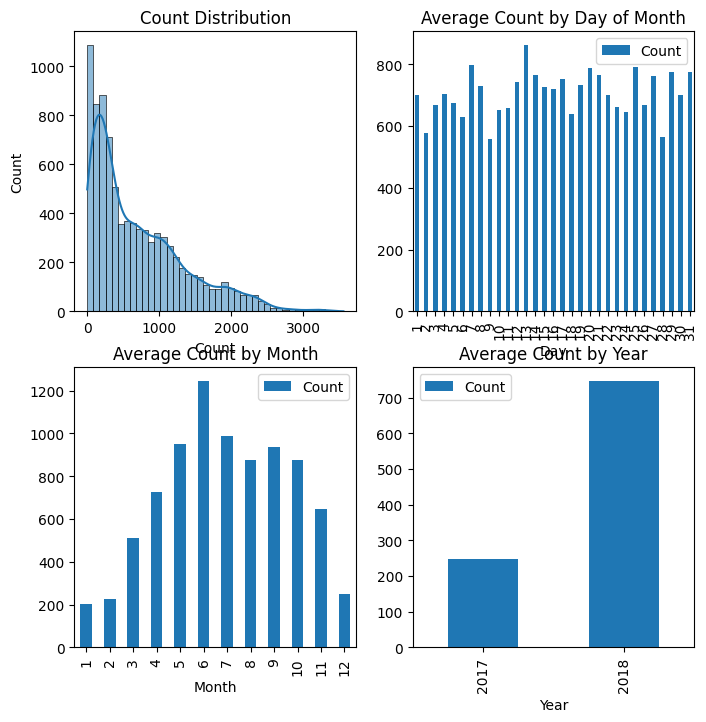

In [42]:


## plot average count over time to look for patterns that can be used to predict future demand
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
data['Day'] = data['Date'].dt.day

## Show all plots on one figure
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
sns.histplot(data['Count'], kde=True, ax=ax[0, 0]).set_title('Count Distribution')
data.groupby('Day').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[0, 1], title='Average Count by Day of Month')
data.groupby('Month').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[1, 0], title='Average Count by Month')
data.groupby('Year').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[1, 1], title='Average Count by Year')
plt.show()


In [43]:
data.query("HireAvailable=='No'").head()


,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable,Month,Year,Day
3144,2018-04-11,0,0,14.4,82,4.6,1041,11.3,0.0,0.0,0.0,Spring,No,No,4,2018,11
3145,2018-04-11,0,1,13.6,81,3.6,886,10.3,0.0,0.0,0.0,Spring,No,No,4,2018,11
3146,2018-04-11,0,2,12.7,80,3.9,885,9.3,0.0,0.0,0.0,Spring,No,No,4,2018,11
3147,2018-04-11,0,3,11.6,81,3.1,687,8.4,0.0,0.0,0.0,Spring,No,No,4,2018,11
3148,2018-04-11,0,4,10.2,83,3.5,554,7.4,0.0,0.0,0.0,Spring,No,No,4,2018,11


## Set up representation

In [44]:
!pip install deap

In [45]:
from deap import base, creator, tools, algorithms, gp, creator
import random
import operator


In [46]:
## Prepare data for training
data['Windspeed'] = data['Wind speed']
data['HireAvailable'] = data['HireAvailable'].map({'Yes': 1, 'No': 0})
data['PublicHoliday'] = data['Public Holiday'].map({'Yes': 1, 'No': 0})
## Create a new column for weekend and assign 1 if the day is a weekend and 0 if it is not from date
data['Weekend'] = data['Date'].dt.dayofweek.map(lambda x: 1 if x > 4 else 0)
data['Season'] = data['Season'].map({'Spring': 0, 'Summer': 1, 'Autumn': 2, 'Winter': 3})
data.head()

,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable,Month,Year,Day,Windspeed,PublicHoliday,Weekend
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,2.2,0,0
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,0.8,0,0
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,3,No,1,12,2017,1,1.0,0,0
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,0.9,0,0
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,3,No,1,12,2017,1,2.3,0,0


In [47]:
data["Count"].describe()

count    8760.000000
mean      704.602055
std       644.997468
min         0.000000
25%       191.000000
50%       504.500000
75%      1065.250000
max      3556.000000
Name: Count, dtype: float64

In [48]:
SET_ARITY = 3
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)
toolbox = base.Toolbox()
pset = gp.PrimitiveSet("main", SET_ARITY)
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=3, max_=5)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)


def evaluateFunction(individual):
    func = toolbox.compile(expr=individual)
    fitness = 0
    for i in range(len(data)):
        ## inputs ['Date', 'Count', 'Hour', 'Temp', 'Humidity', 'Wind speed', 'Visibility', 'Dew point', 'Sunshine', 'Rain', 'Snow', 'Season', 'Public Holiday', 'HireAvailable', 'Month', 'Year', 'Day', 'WorkingDay', 'Weekend']
        try:
          fitness += abs(func(data['Month'][i], data['Humidity'][i], data['Weekend'][i]) - data['Count'][i])

        except:
          return (10000000,)
    # Check if inf or nan
    if fitness == float('inf'):
      fitness = 10000000

    return fitness,

toolbox.register("evaluate", evaluateFunction)

pset.addPrimitive(operator.add, 2)
# pset.addPrimitive(operator.pow, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.neg, 1)

# pset.addPrimitive(np.sin, 1)
# pset.addPrimitive(np.cos, 1)
# pset.addPrimitive(np.tan, 1)
pset.addPrimitive(np.abs, 1)
# pset.addEphemeralConstant("rand101", lambda: random.randint(, 100000000))



toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=8))
toolbox.decorate(
    "mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=8)
)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


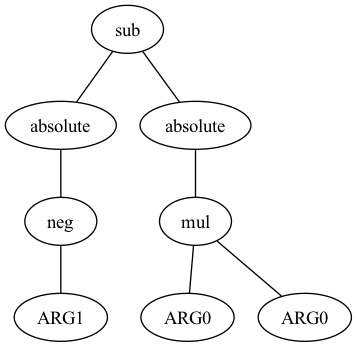

In [49]:
import pygraphviz as pgv
from IPython.display import Image

ind = toolbox.individual()

nodes, edges, labels = gp.graph(ind)
tree = pgv.AGraph()
tree.add_nodes_from(nodes)
tree.add_edges_from(edges)
tree.layout(prog="dot")

for i in nodes:
    n = tree.get_node(i)
    n.attr["label"] = labels[i]

treePlot = tree.draw(format="png", prog="dot")
Image(treePlot)

In [50]:
import numpy

stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)


In [51]:
from deap import algorithms

pop = toolbox.population(n=200)
hof = tools.HallOfFame(1)

pop, log = algorithms.eaSimple(
    pop,
    toolbox,
    cxpb=0.5,
    mutpb=0.1,
    ngen=150,
    stats=mstats,
    halloffame=hof,
    verbose=True,
)


   	      	                                  fitness                                  	                      size                     
   	      	---------------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg        	gen	max        	min        	nevals	std        	avg 	gen	max	min	nevals	std    
0  	200   	7.67213e+09	0  	1.28479e+12	4.84824e+06	200   	9.14278e+10	16.2	0  	51 	4  	200   	9.80969
1  	115   	3.52401e+07	1  	4.72241e+09	4.85171e+06	115   	3.35926e+08	13.875	1  	48 	1  	115   	8.70054
2  	119   	1.25203e+07	2  	5.79656e+08	4.85034e+06	119   	4.69189e+07	15.89 	2  	45 	1  	119   	9.29774
3  	106   	2.00778e+07	3  	2.37126e+09	4.84635e+06	106   	1.68095e+08	18.195	3  	47 	2  	106   	10.3105
4  	116   	9.4396e+06 	4  	2.23953e+08	4.84635e+06	116   	2.67204e+07	19.625	4  	56 	3  	116   	10.6379
5  	111   	2.36871e+07	5  	2.36258e+09	4.84545e+06	111   	1.69585e+08	21.215	5  	47 	3  	111   	8.93022
6  	12

sub(sub(add(add(absolute(add(add(add(ARG2, ARG0), add(ARG0, ARG0)), add(add(ARG0, ARG0), add(ARG0, ARG0)))), add(add(add(ARG0, ARG0), add(add(ARG2, ARG0), add(ARG0, ARG0))), add(add(add(ARG0, ARG0), add(ARG0, ARG0)), add(add(ARG0, ARG0), add(ARG0, ARG0))))), add(add(ARG0, add(add(add(ARG0, ARG0), add(ARG0, ARG0)), add(add(ARG0, ARG0), add(ARG0, ARG0)))), add(add(add(add(ARG0, ARG0), add(ARG0, ARG0)), add(add(ARG0, ARG0), add(ARG0, ARG0))), add(ARG0, ARG1)))), add(absolute(sub(mul(add(add(ARG0, ARG0), add(ARG0, ARG0)), ARG0), add(ARG1, add(add(ARG0, ARG0), add(ARG0, ARG0))))), sub(ARG1, add(add(add(add(ARG0, ARG0), add(ARG0, ARG0)), add(ARG2, add(ARG0, ARG0))), add(add(add(ARG0, ARG0), add(ARG0, ARG0)), add(ARG0, add(ARG0, ARG0))))))), add(sub(mul(ARG2, add(add(ARG0, ARG0), add(ARG0, ARG0))), add(add(add(add(add(ARG0, ARG0), add(ARG0, ARG0)), add(add(ARG0, ARG0), add(ARG0, ARG0))), add(add(add(ARG0, ARG0), add(ARG0, ARG0)), add(ARG0, add(ARG0, ARG0)))), add(add(add(add(ARG0, ARG0), add(

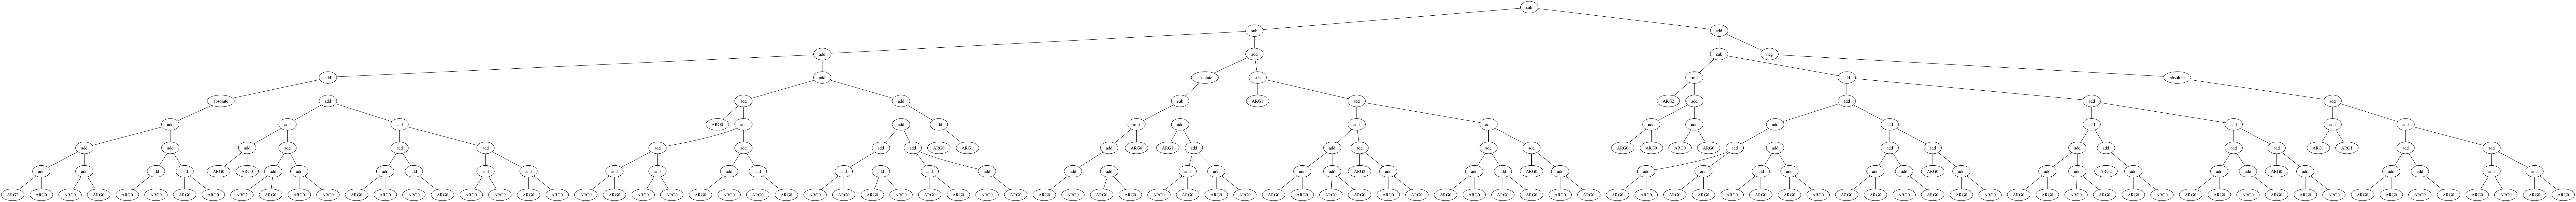

In [ ]:

import pygraphviz as pgv
from IPython.display import Image
best_ind = tools.selBest(pop, 1)[0]
print(best_ind)
print(best_ind.fitness)
nodes, edges, labels = gp.graph(best_ind)

tree = pgv.AGraph()
tree.add_nodes_from(nodes)
tree.add_edges_from(edges)
tree.layout(prog="dot")

for i in nodes:
    n = tree.get_node(i)
    n.attr["label"] = labels[i]

treePlot = tree.draw(format="png", prog="dot")
Image(treePlot)